# Hypothesis 4: Broadband adoption gaps, not service availability, are the primary digital food access barrier in urban food deserts—exacerbated by poverty and elderly populations.

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium
from folium import plugins
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import requests

API_KEY = ""

base_url = 'https://api.census.gov/data/2019/acs/acs5'
variables = 'B28002_001E,B28002_004E,NAME'
geography = 'for=tract:*&in=state:17&in=county:031'
url = f"{base_url}?get={variables}&{geography}&key={API_KEY}"

# Call the API
response = requests.get(url)
response.raise_for_status()
data = response.json()

# First row is header; rest are data
cols = data[0]
rows = data[1:]

df = pd.DataFrame(rows, columns=cols)

# Cast numeric columns
df["B28002_001E"] = pd.to_numeric(df["B28002_001E"])
df["B28002_004E"] = pd.to_numeric(df["B28002_004E"])

# Example: compute share with broadband subscription
df["broadband_share"] = df["B28002_004E"] / df["B28002_001E"]


**What this does:**
- Retrieves tract-level broadband subscription data from the 2019 American Community Survey (ACS) via Census API

**Variables:**

- B28002_001E: Total households

- B28002_004E: Households with broadband subscription

- Geography: Cook County, Illinois (state FIPS 17, county FIPS 031)

**Output interpretation:**

The resulting dataframe shows broadband adoption rates ranging from ~56% to ~85% across Cook County tracts, indicating substantial digital divide.

In [ ]:
df.head()

,B28002_001E,B28002_004E,NAME,state,county,tract,broadband_share
0,575,392,"Census Tract 6302, Cook County, Illinois",17,031,630200,0.681739
1,1544,1242,"Census Tract 5807, Cook County, Illinois",17,031,580700,0.804404
2,1172,917,"Census Tract 5906, Cook County, Illinois",17,031,590600,0.782423
3,1084,917,"Census Tract 6007, Cook County, Illinois",17,031,600700,0.845941
4,574,322,"Census Tract 6119, Cook County, Illinois",17,031,611900,0.560976


In [ ]:

# 1) Load atlas
atlas = pd.read_csv("atlas_chicago_clean_2019.csv")

# Fix GEOID format
atlas["GEOID"] = atlas["GEOID"].astype(str).str.zfill(11)

# Optional: rename to simpler names
atlas = atlas.rename(
    columns={
        "Pct_Seniors": "pct_seniors",
        "Pct_NoVehicle": "pct_no_vehicle",
        "Low_Income_Tract": "low_income_flag",
        "Food_Desert_1and10": "food_desert_flag",
        "LA1and10": "la1and10_flag",
    }
)


In [ ]:
broadband = df.copy()

broadband["state"] = broadband["state"].astype(str).str.zfill(2)
broadband["county"] = broadband["county"].astype(str).str.zfill(3)
broadband["tract"] = broadband["tract"].astype(str).str.zfill(6)
broadband["GEOID"] = broadband["state"] + broadband["county"] + broadband["tract"]

tract = atlas.merge(
    broadband[["GEOID", "broadband_share"]],
    on="GEOID",
    how="left",
)


In [ ]:
low_broadband_thresh = tract["broadband_share"].median()

tract["is_food_desert"] = tract["food_desert_flag"] == 1
tract["is_low_income"] = tract["low_income_flag"] == 1
tract["low_broadband"] = tract["broadband_share"] < low_broadband_thresh

tract["barrier"] = (
    tract["is_food_desert"]
    & tract["is_low_income"]
    & tract["low_broadband"]
)

# Convenience variables
tract["pct_seniors"] = tract["pct_seniors"]  # already renamed


In [ ]:
tract.groupby("barrier")[["pct_seniors", "broadband_share"]].agg(["mean", "count"])

pct_seniors       broadband_share      
               mean count            mean count
barrier                                        
False     11.744739  1282        0.798702  1282
True      12.969133    32        0.712515    32

In [ ]:
import statsmodels.formula.api as smf

# Make sure barrier is numeric 0/1
model_data = tract.dropna(subset=["broadband_share", "pct_seniors"]).copy()
model_data["barrier_num"] = model_data["barrier"].astype(int)

# Also ensure predictors are numeric
model_data["pct_seniors"] = pd.to_numeric(model_data["pct_seniors"], errors="coerce")
model_data["PovertyRate"] = pd.to_numeric(model_data["PovertyRate"], errors="coerce")
model_data["pct_no_vehicle"] = pd.to_numeric(model_data["pct_no_vehicle"], errors="coerce")
model_data["low_income_flag"] = pd.to_numeric(model_data["low_income_flag"], errors="coerce")

model_data = model_data.dropna(
    subset=["barrier_num", "pct_seniors", "PovertyRate", "pct_no_vehicle", "low_income_flag"]
)

# logit = smf.logit(
#     "barrier_num ~ pct_seniors + PovertyRate + pct_no_vehicle + low_income_flag",
#     data=model_data
# ).fit()

# print(logit.summary())


In [ ]:
model_data[["barrier_num", "pct_seniors", "PovertyRate",
            "pct_no_vehicle", "low_income_flag"]].describe()
model_data["barrier_num"].value_counts()


,count
barrier_num,
0,1282
1,32


In [ ]:
from sklearn.preprocessing import StandardScaler

md = model_data.copy()

# Keep only continuous predictors first
cols = ["pct_seniors", "PovertyRate", "pct_no_vehicle"]
md = md.dropna(subset=cols + ["barrier_num"]).copy()

scaler = StandardScaler()
md[cols] = scaler.fit_transform(md[cols])

import statsmodels.formula.api as smf

logit = smf.logit(
    "barrier_num ~ pct_seniors + PovertyRate + pct_no_vehicle",
    data=md
).fit(maxiter=100)

print(logit.summary())


Optimization terminated successfully.
         Current function value: 0.104693
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:            barrier_num   No. Observations:                 1314
Model:                          Logit   Df Residuals:                     1310
Method:                           MLE   Df Model:                            3
Date:                Tue, 02 Dec 2025   Pseudo R-squ.:                 0.08587
Time:                        03:27:39   Log-Likelihood:                -137.57
converged:                       True   LL-Null:                       -150.49
Covariance Type:            nonrobust   LLR p-value:                 1.027e-05
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -4.0667      0.234    -17.375      0.000      -4.525      -3.608
pct_seniors      

In [ ]:
import numpy as np
np.exp(logit.params)


,0
Intercept,0.017133
pct_seniors,1.523049
PovertyRate,3.061521
pct_no_vehicle,0.438155


In [ ]:
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf

md = model_data.copy()

# Add / standardize urban measure
md["urban_share"] = pd.to_numeric(md["Urban"], errors="coerce")  # or UrbanPop2010
cols = ["pct_seniors", "PovertyRate", "pct_no_vehicle", "urban_share"]
md = md.dropna(subset=cols + ["barrier_num"]).copy()

scaler = StandardScaler()
md[cols] = scaler.fit_transform(md[cols])

logit_urb = smf.logit(
    "barrier_num ~ pct_seniors * urban_share + PovertyRate + pct_no_vehicle",
    data=md
).fit(maxiter=100)

print(logit_urb.summary())


         Current function value: 0.104655
         Iterations: 100
                           Logit Regression Results                           
Dep. Variable:            barrier_num   No. Observations:                 1314
Model:                          Logit   Df Residuals:                     1308
Method:                           MLE   Df Model:                            5
Date:                Tue, 02 Dec 2025   Pseudo R-squ.:                 0.08621
Time:                        03:27:39   Log-Likelihood:                -137.52
converged:                      False   LL-Null:                       -150.49
Covariance Type:            nonrobust   LLR p-value:                 9.138e-05
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -4.1030   1.68e+04     -0.000      1.000    -3.3e+04     3.3e+04
pct_seniors              

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf

# Ensure barrier exists and is numeric 0/1
tract["barrier_num"] = tract["barrier"].astype(int)

# Make sure column names match atlas
# pct_seniors, PovertyRate, pct_no_vehicle, Urban should already exist
print(tract.columns)

md = tract.dropna(
    subset=["barrier_num", "pct_seniors", "PovertyRate", "pct_no_vehicle", "Urban"]
).copy()

# Standardize continuous predictors
cols = ["pct_seniors", "PovertyRate", "pct_no_vehicle", "Urban"]
scaler = StandardScaler()
md[cols] = scaler.fit_transform(md[cols])

logit_urb = smf.logit(
    "barrier_num ~ pct_seniors * Urban + PovertyRate + pct_no_vehicle",
    data=md
).fit(maxiter=100)

print(logit_urb.summary())


Index(['GEOID', 'State', 'County', 'Urban', 'Pop2010', 'PovertyRate',
       'MedianFamilyIncome', 'TractSNAP', 'TractSeniors', 'TractHUNV',
       'OHU2010', 'Pct_SNAP', 'pct_seniors', 'pct_no_vehicle',
       'low_income_flag', 'food_desert_flag', 'la1and10_flag',
       'broadband_share', 'is_food_desert', 'is_low_income', 'low_broadband',
       'barrier', 'barrier_num'],
      dtype='object')
         Current function value: 0.104655
         Iterations: 100
                           Logit Regression Results                           
Dep. Variable:            barrier_num   No. Observations:                 1314
Model:                          Logit   Df Residuals:                     1308
Method:                           MLE   Df Model:                            5
Date:                Tue, 02 Dec 2025   Pseudo R-squ.:                 0.08621
Time:                        03:27:40   Log-Likelihood:                -137.52
converged:                      False   LL-Null:          

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


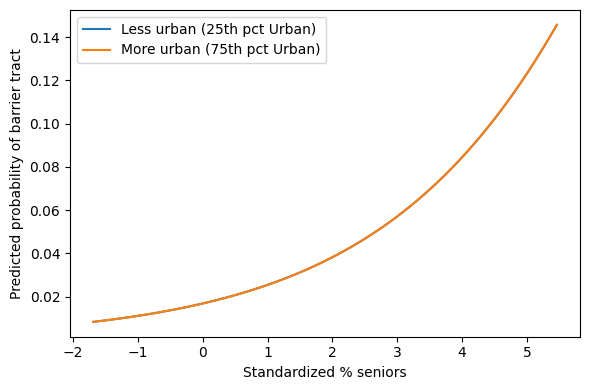

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Make a grid of seniors and two urban levels (low / high)
sen_grid = np.linspace(md["pct_seniors"].min(), md["pct_seniors"].max(), 100)
urban_low = md["Urban"].quantile(0.25)
urban_high = md["Urban"].quantile(0.75)

def predict_curve(urban_level):
    tmp = pd.DataFrame({
        "pct_seniors": sen_grid,
        "Urban": urban_level,
        "PovertyRate": 0,        # average after standardization
        "pct_no_vehicle": 0
    })
    tmp["pred"] = logit_urb.predict(tmp)
    return tmp

curve_low = predict_curve(urban_low)
curve_high = predict_curve(urban_high)

plt.figure(figsize=(6,4))
plt.plot(curve_low["pct_seniors"], curve_low["pred"], label="Less urban (25th pct Urban)")
plt.plot(curve_high["pct_seniors"], curve_high["pred"], label="More urban (75th pct Urban)")
plt.xlabel("Standardized % seniors")
plt.ylabel("Predicted probability of barrier tract")
plt.legend()
plt.tight_layout()
plt.show()


Random forest ROC AUC: 0.7680519480519481


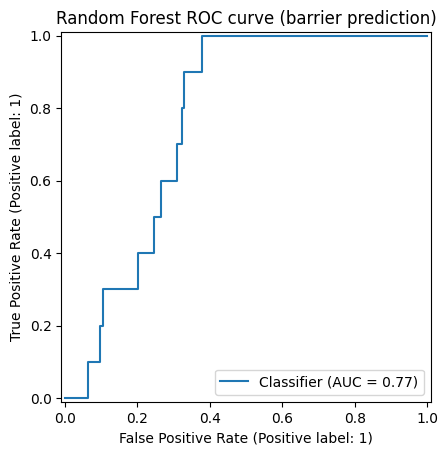

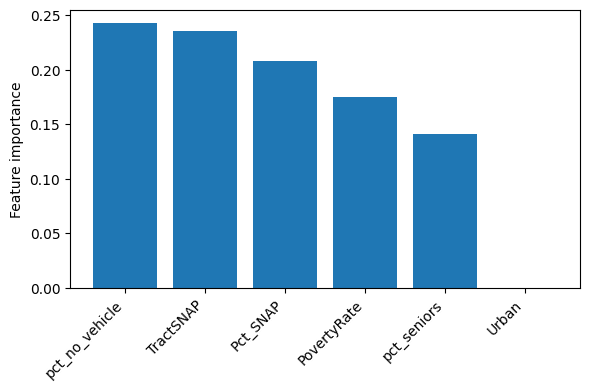

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
import numpy as np

# Ensure target exists
tract["barrier_num"] = tract["barrier"].astype(int)

# Use columns that exist: seniors, poverty, no vehicle, SNAP, urban
feat_cols = [
    "pct_seniors", "PovertyRate", "pct_no_vehicle",
    "Pct_SNAP", "TractSNAP", "Urban"
]

# Drop rows with missing feature or target values
ml = tract.dropna(subset=feat_cols + ["barrier_num"]).copy()

X = ml[feat_cols]
y = ml["barrier_num"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# ROC AUC + curve
y_prob = rf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_prob)
print("Random forest ROC AUC:", auc)

RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title("Random Forest ROC curve (barrier prediction)")
plt.show()

# Feature importance plot
importances = rf.feature_importances_
idx = np.argsort(importances)[::-1]

plt.figure(figsize=(6,4))
plt.bar(range(len(feat_cols)), importances[idx])
plt.xticks(range(len(feat_cols)), np.array(feat_cols)[idx], rotation=45, ha="right")
plt.ylabel("Feature importance")
plt.tight_layout()
plt.show()


In [ ]:
print([c for c in tract.columns if "Low" in c or "SNAP" in c or "Urban" in c])


['Urban', 'TractSNAP', 'Pct_SNAP']


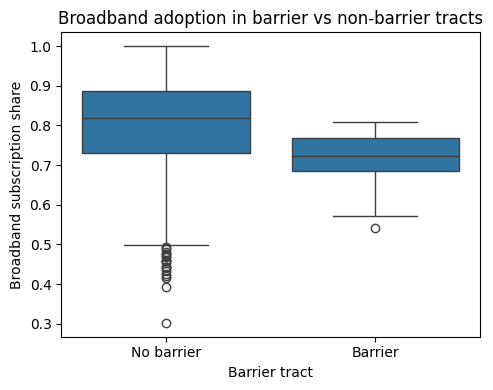

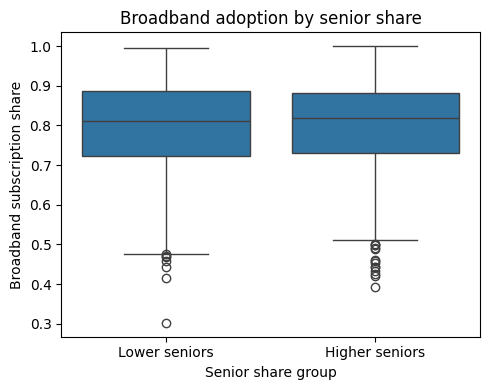

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Barrier vs non-barrier
plt.figure(figsize=(5,4))
sns.boxplot(data=tract, x="barrier_num", y="broadband_share")
plt.xticks([0,1], ["No barrier", "Barrier"])
plt.xlabel("Barrier tract")
plt.ylabel("Broadband subscription share")
plt.title("Broadband adoption in barrier vs non-barrier tracts")
plt.tight_layout()
plt.show()

# 2) High vs low seniors
median_seniors = tract["pct_seniors"].median()
tract["senior_group"] = (tract["pct_seniors"] > median_seniors).map(
    {False: "Lower seniors", True: "Higher seniors"}
)

plt.figure(figsize=(5,4))
sns.boxplot(data=tract, x="senior_group", y="broadband_share")
plt.xlabel("Senior share group")
plt.ylabel("Broadband subscription share")
plt.title("Broadband adoption by senior share")
plt.tight_layout()
plt.show()


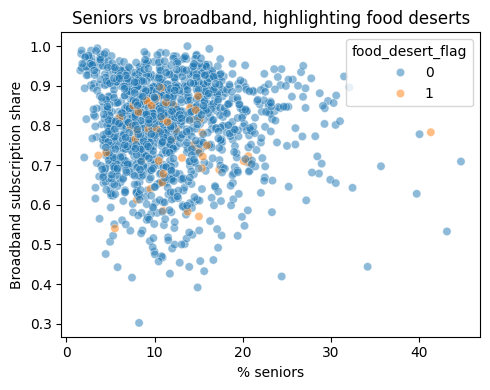

In [ ]:
plt.figure(figsize=(5,4))
sns.scatterplot(
    data=tract,
    x="pct_seniors",
    y="broadband_share",
    hue="food_desert_flag",
    alpha=0.5
)
plt.xlabel("% seniors")
plt.ylabel("Broadband subscription share")
plt.title("Seniors vs broadband, highlighting food deserts")
plt.tight_layout()
plt.show()


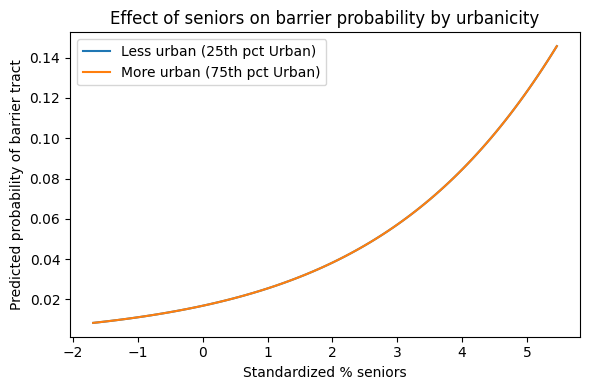

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assume md and logit_urb from earlier
sen_grid = np.linspace(md["pct_seniors"].min(), md["pct_seniors"].max(), 100)
urban_low = md["Urban"].quantile(0.25)
urban_high = md["Urban"].quantile(0.75)

def pred_curve(urban_level):
    tmp = pd.DataFrame({
        "pct_seniors": sen_grid,
        "Urban": urban_level,
        "PovertyRate": 0,
        "pct_no_vehicle": 0
    })
    tmp["pred"] = logit_urb.predict(tmp)
    return tmp

curve_low = pred_curve(urban_low)
curve_high = pred_curve(urban_high)

plt.figure(figsize=(6,4))
plt.plot(curve_low["pct_seniors"], curve_low["pred"], label="Less urban (25th pct Urban)")
plt.plot(curve_high["pct_seniors"], curve_high["pred"], label="More urban (75th pct Urban)")
plt.xlabel("Standardized % seniors")
plt.ylabel("Predicted probability of barrier tract")
plt.title("Effect of seniors on barrier probability by urbanicity")
plt.legend()
plt.tight_layout()
plt.show()


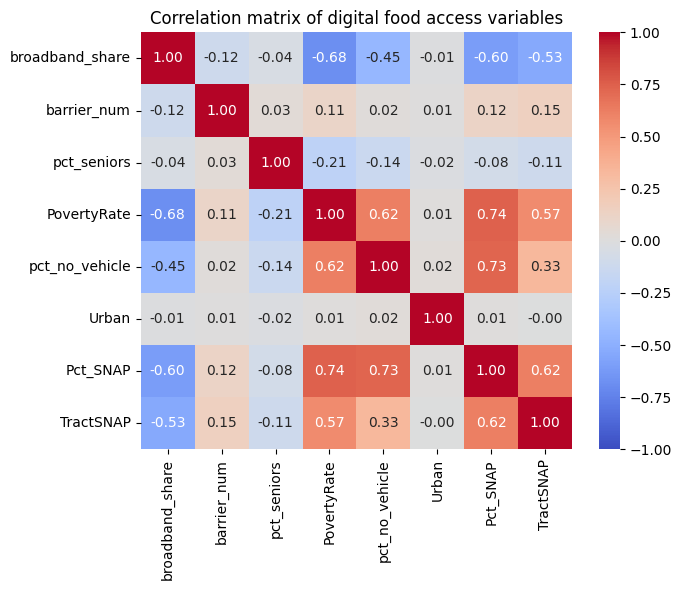

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

cols = [
    "broadband_share", "barrier_num", "pct_seniors",
    "PovertyRate", "pct_no_vehicle", "Urban",
    "Pct_SNAP", "TractSNAP"
]

corr = tract[cols].corr()

plt.figure(figsize=(7,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation matrix of digital food access variables")
plt.tight_layout()
plt.show()


Urban
1    918
0      1
Name: count, dtype: int64


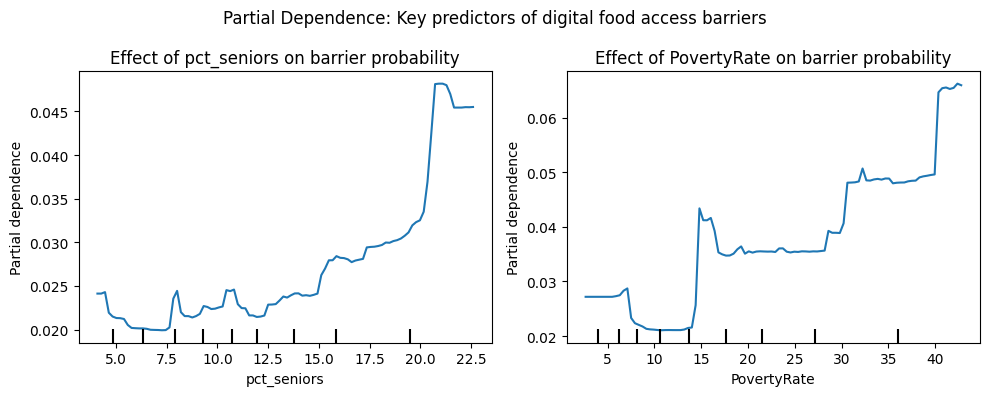

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

features_to_plot = ["pct_seniors", "PovertyRate"]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for idx, feat in enumerate(features_to_plot):
    PartialDependenceDisplay.from_estimator(
        rf,
        X_train,
        features=[feat],
        ax=axes[idx]
    )
    axes[idx].set_title(f"Effect of {feat} on barrier probability")

plt.suptitle("Partial Dependence: Key predictors of digital food access barriers")
plt.tight_layout()
plt.show()


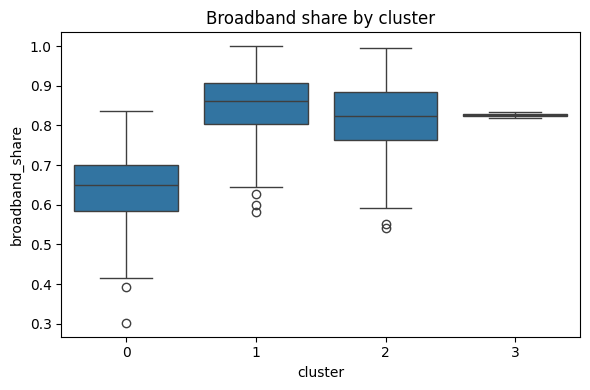

In [ ]:
plt.figure(figsize=(6,4))
sns.boxplot(data=cluster_data, x="cluster", y="broadband_share")
plt.title("Broadband share by cluster")
plt.tight_layout()
plt.show()


<Figure size 500x400 with 0 Axes>

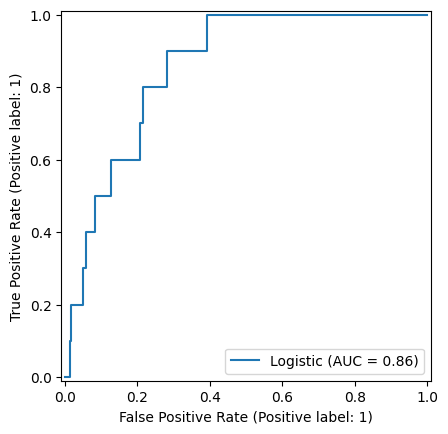

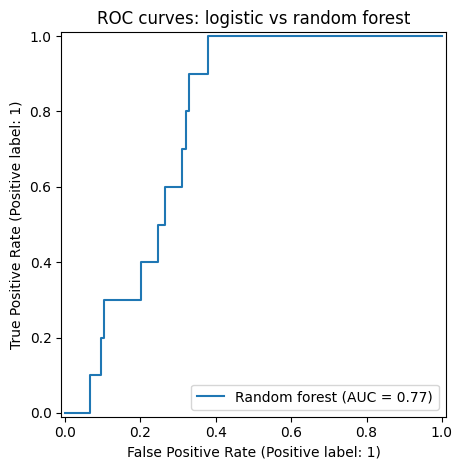

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import RocCurveDisplay

# Use same X_train, X_test, y_train, y_test as RF
log_clf = LogisticRegression(max_iter=1000)
log_clf.fit(X_train, y_train)

y_prob_log = log_clf.predict_proba(X_test)[:, 1]

plt.figure(figsize=(5,4))
RocCurveDisplay.from_predictions(y_test, y_prob_log, name="Logistic")
RocCurveDisplay.from_predictions(y_test, y_prob, name="Random forest")  # y_prob from RF
plt.title("ROC curves: logistic vs random forest")
plt.tight_layout()
plt.show()


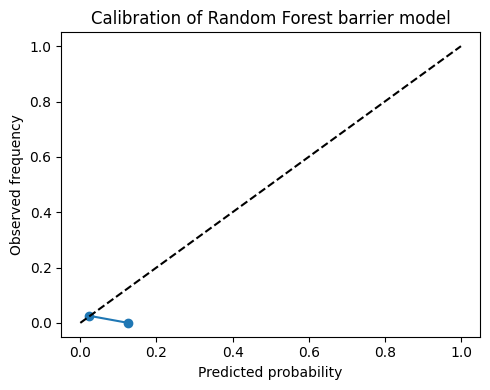

In [ ]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)

plt.figure(figsize=(5,4))
plt.plot(prob_pred, prob_true, marker="o")
plt.plot([0,1],[0,1], "k--")
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.title("Calibration of Random Forest barrier model")
plt.tight_layout()
plt.show()
